### Steps carried out
 1. Train the model with a backdoor trigger with 100% intensity added to all number 8 labels in the malicious clients.
 2. Conduct three sets of experiments.

**Experiments:**

(I) Add the backdoor on all the data points and calculate the misclassification of all the labels and only #8.

(II) Change the intensity and analyze how the misclassification varies.

(III) Change the position of the backdoor randomly across all data points and see how the results get changed.

In [8]:
# LOAD THE TEST DATA AND IMPORT REQUIRED DEPENDENCIES
from fedn import APIClient
import random
import time
import uuid
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from fedn.utils.helpers.helpers import get_helper, save_metadata, save_metrics

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

HELPER_MODULE = 'numpyhelper'
helper = get_helper(HELPER_MODULE)

def load_data(data_path, is_train=True):
    """ Load data from disk.

    :param data_path: Path to data file.
    :type data_path: str
    :param is_train: Whether to load training or test data.
    :type is_train: bool
    :return: Tuple of data and labels.
    :rtype: tuple
    """
    if data_path is None:
        data = torch.load(_get_data_path())
    else:
        data = torch.load(data_path)

    if is_train:
        X = data['x_train']
        y = data['y_train']
    else:
        X = data['x_test']
        y = data['y_test']

    # Normalize
    X = X / 255

    return X, y

def compile_model():
    """ Compile the pytorch model.

    :return: The compiled model.
    :rtype: torch.nn.Module
    """
    torch.manual_seed(42)

    class Net(torch.nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = torch.nn.Linear(784, 64)
            self.fc2 = torch.nn.Linear(64, 32)
            self.fc3 = torch.nn.Linear(32, 10)

        def forward(self, x):
            x = torch.nn.functional.relu(self.fc1(x.reshape(x.size(0), 784)))
            x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
            x = torch.nn.functional.relu(self.fc2(x))
            x = torch.nn.functional.log_softmax(self.fc3(x), dim=1)
            return x

    return Net()

def load_parameters(model_path):
    """ Load model parameters from file and populate model.

    param model_path: The path to load from.
    :type model_path: str
    :return: The loaded model.
    :rtype: torch.nn.Module
    """
    model = compile_model()
    parameters_np = helper.load(model_path)

    params_dict = zip(model.state_dict().keys(), parameters_np)
    state_dict = collections.OrderedDict({key: torch.tensor(x) for key, x in params_dict})
    model.load_state_dict(state_dict, strict=True)
    return model

# Specify the trained models with different malicious client proportions
models = [
    "MNIST_BD__IN__P_25R_20_00",
    "MNIST_BD02IN05P_25R_19_01",
    "MNIST_BD02IN05P_25R_18_02",
    "MNIST_BD02IN05P_25R_16_04"
]

### How does a backdoor trigger (a + sign) with a given intensity level look like?

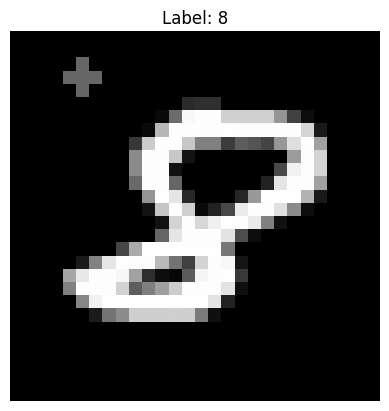

In [9]:
x_test, y_test = load_data('../data/clients/1/mnist.pt', is_train=False)

# Access and show the first image
t = 61
intensity = 400 / 1000

x_test[t][2] = torch.tensor([intensity if (x > 4 and x <= 5) else 0 for x in range(28)])
x_test[t][3] = torch.tensor([intensity if (x > 3 and x <= 6) else 0 for x in range(28)])
x_test[t][4] = torch.tensor([intensity if (x > 4 and x <= 5) else 0 for x in range(28)])

image = x_test[t]
plt.imshow(image.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
plt.title(f"Label: {y_test[t]}")
plt.axis('off')  # Hide axis
plt.show()

## (I) - Add the backdoor on all the data points and calculate the misclassification of all the labels and only #8.

In [10]:
graph_data = {}

for model in models:
    model_name = f"{int(int(model[-2:])*100/(int(model[-2:]) + int(model[-5:-3])))}% malicious"
    graph_data[model_name] = {}
    
    x_test, y_test = load_data('../data/clients/1/mnist.pt', is_train=False)
    for point in x_test:
        point[2] = torch.tensor([1 if (x > 4 and x <= 5) else 0 for x in range(28)])
        point[3] = torch.tensor([1 if (x > 3 and x <= 6) else 0 for x in range(28)])
        point[4] = torch.tensor([1 if (x > 4 and x <= 5) else 0 for x in range(28)])

    trained_model = load_parameters(f"backdoor_models/{model}")
    trained_model.eval()

    with torch.no_grad():
        test_out = trained_model(x_test)
    _, y_pred = torch.max(test_out, 1)
    graph_data[model_name]['total_misclassification'] = np.mean((y_pred != y_test).tolist())
    graph_data[model_name]['8s_misclassified_to_non_8s'] = np.mean((y_pred[y_test == 8] != 8).tolist())
    graph_data[model_name]['non_8s_misclassified_to_8'] = np.mean((y_pred[y_test != 8] == 8).tolist())

In [11]:
results_table = pd.DataFrame.from_dict(graph_data, orient='index')
results_table = results_table.reset_index().rename(columns={'index': 'model'})
results_table

,model,total_misclassification,8s_misclassified_to_non_8s,non_8s_misclassified_to_8
0,0% malicious,0.1322,0.187885,0.020386
1,5% malicious,0.1333,0.185832,0.021604
2,10% malicious,0.1322,0.177618,0.022158
3,20% malicious,0.1327,0.168378,0.024706


In [12]:
graph_data = {}
labels = [x for x in range(10)]

for model in models:
    model_name = f"{int(int(model[-2:])*100/(int(model[-2:]) + int(model[-5:-3])))}% malicious"
    trained_model = load_parameters(f"backdoor_models/{model}")
    trained_model.eval()

    with torch.no_grad():
        test_out = trained_model(x_test)
        _, graph_data[model_name] = torch.max(test_out, 1)
        graph_data[model_name] = graph_data[model_name].tolist()
    

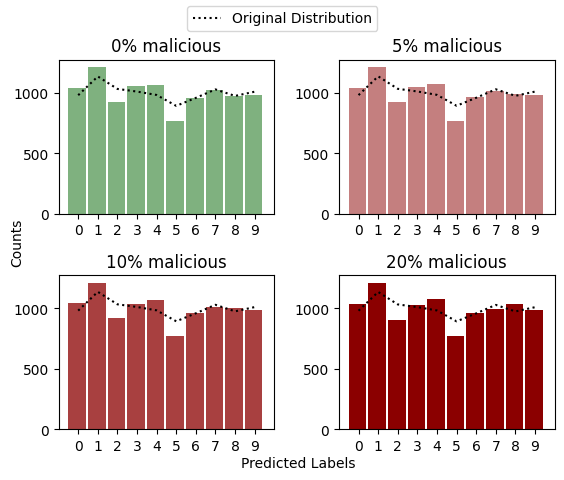

In [13]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(graph_data['0% malicious'], bins=range(11), color='darkgreen', alpha=0.5, align='left', width=0.9)
axs[0, 0].set_title('0% malicious')
axs[0, 1].hist(graph_data['5% malicious'], bins=range(11), color='darkred', alpha=0.5, align='left', width=0.9)
axs[0, 1].set_title('5% malicious')
axs[1, 0].hist(graph_data['10% malicious'], bins=range(11), color='darkred', alpha=0.75, align='left', width=0.9)
axs[1, 0].set_title('10% malicious')
axs[1, 1].hist(graph_data['20% malicious'], bins=range(11), color='darkred', alpha=1, align='left', width=0.9)
axs[1, 1].set_title('20% malicious')

# Calculate histogram data for y_test
y_test_hist, _ = np.histogram(y_test, bins=range(11))

# Plot y_test as a dotted line over the histograms
original_distributions = []
for ax in axs.flat:
    line, = ax.plot(range(10), y_test_hist, linestyle=':', color='black')
    original_distributions.append(line)

# Add a single legend for the black dotted line
fig.legend(original_distributions, ['Original Distribution'], loc='upper center')
    

# Setting x-axis ticks to be discrete values between 0 and 9 for all subplots
for ax in axs.flat:
    ax.set_xticks(range(10))

# Add common x and y axis labels
fig.text(0.5, 0.04, 'Predicted Labels', ha='center', va='center')
fig.text(0.06, 0.5, 'Counts', ha='center', va='center', rotation='vertical')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # hspace and wspace control the space between plots

# Display the plot
plt.show()

***Conclusions***

* Total misclassification increases with the malicious proportion since higher the number of training data points having the backdoor trigger, more the model would learn to use the trigger as a key feature to classify a data point to #8. Since we have the trigger in all the training data, more datapoints should be classified as #8 - this can be validated using the histograms.
* Misclassification of #8 decreases with the malicious proportion since higher the number of training data points having the backdoor trigger, more the model would learn to use the trigger as a key feature to classify a data point to #8. This affect is magnified for the test data points with the label 8. The trigger becomes a key feature as well as other common features which belongs to datapoints with #8 label. Hence, more test data points which belongs to label #8 will get classified correctly as #8.

## (II) Change the intensity and analyze how the misclassification varies.

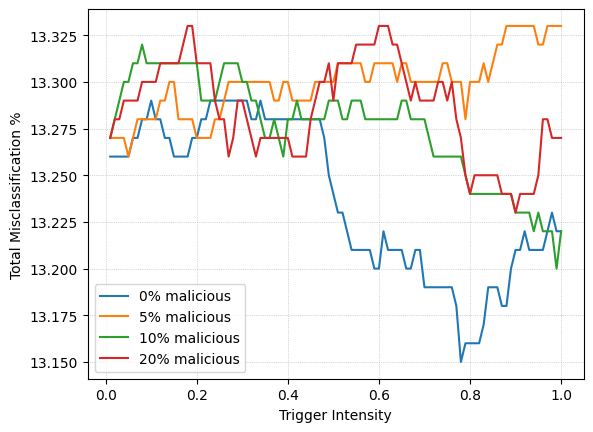

In [14]:
intensities = [x / 100 for x in range(1, 101)]

total_iterations = len(models) * len(intensities)
counter = 0

graph_data = {}

for model in models:
    graph_data[model] = []
    for intensity in intensities:
        x_test, y_test = load_data('../data/clients/1/mnist.pt', is_train=False)
        for point in x_test:
            point[2] = torch.tensor([intensity if (x > 4 and x <= 5) else 0 for x in range(28)])
            point[3] = torch.tensor([intensity if (x > 3 and x <= 6) else 0 for x in range(28)])
            point[4] = torch.tensor([intensity if (x > 4 and x <= 5) else 0 for x in range(28)])

        trained_model = load_parameters(f"backdoor_models/{model}")
        trained_model.eval()
        
        with torch.no_grad():
            test_out = trained_model(x_test)
        _, y_pred = torch.max(test_out, 1)
        graph_data[model].append(np.mean((y_pred != y_test).tolist()))
        print(f"{counter + 1} / {total_iterations} completed!", end="\r")
        counter += 1

for key in graph_data.keys():
    plt.plot(intensities, [value * 100 for value in graph_data[key]])

plt.legend(
    [
        f"{int(int(key[-2:])*100/(int(key[-2:]) + int(key[-5:-3])))}% malicious"
        for key in graph_data.keys()
    ]
)

plt.grid(True, linestyle=':', linewidth=0.5)
plt.ylabel(f"Total Misclassification %")
plt.xlabel(f'Trigger Intensity')

plt.show()

**Explanation**

Total mmisclassification is the percentage of data points which were misclassified. This value should ideally be increasing with increasing intensity, since the models detects the trigger more when it has a high level of intensity. But the misclassification does not seem to be significant enough to hide a trigger using low intensity.

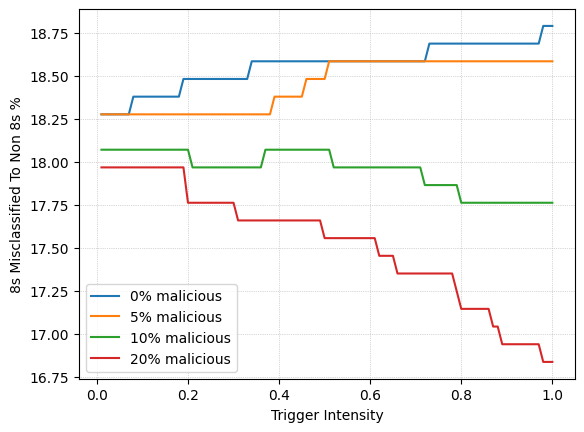

In [15]:
intensities = [x / 100 for x in range(1, 101)]

total_iterations = len(models) * len(intensities)
counter = 0

graph_data = {}

for model in models:
    graph_data[model] = []
    for intensity in intensities:
        x_test, y_test = load_data('../data/clients/1/mnist.pt', is_train=False)
        for point in x_test:
            point[2] = torch.tensor([intensity if (x > 4 and x <= 5) else 0 for x in range(28)])
            point[3] = torch.tensor([intensity if (x > 3 and x <= 6) else 0 for x in range(28)])
            point[4] = torch.tensor([intensity if (x > 4 and x <= 5) else 0 for x in range(28)])

        trained_model = load_parameters(f"backdoor_models/{model}")
        trained_model.eval()
        
        with torch.no_grad():
            test_out = trained_model(x_test)
        _, y_pred = torch.max(test_out, 1)
        graph_data[model].append(np.mean((y_pred[y_test == 8] != 8).tolist()))
        print(f"{counter + 1} / {total_iterations} completed!", end="\r")
        counter += 1

for key in graph_data.keys():
    plt.plot(intensities, [value * 100 for value in graph_data[key]])

plt.legend(
    [
        f"{int(int(key[-2:])*100/(int(key[-2:]) + int(key[-5:-3])))}% malicious"
        for key in graph_data.keys()
    ]
)

plt.grid(True, linestyle=':', linewidth=0.5)
plt.ylabel(f"8s Misclassified To Non 8s %")
plt.xlabel(f'Trigger Intensity')

plt.show()

**Explanation**

This measure is the number of 8s which were misclassified as a % of the number of 8s. This value is decreasing with increasing intensity because the model starts classifying 8s better when more training data points with label 8 has the backdoor trigger. The trigger becomes a significant feature of data points with label 8.

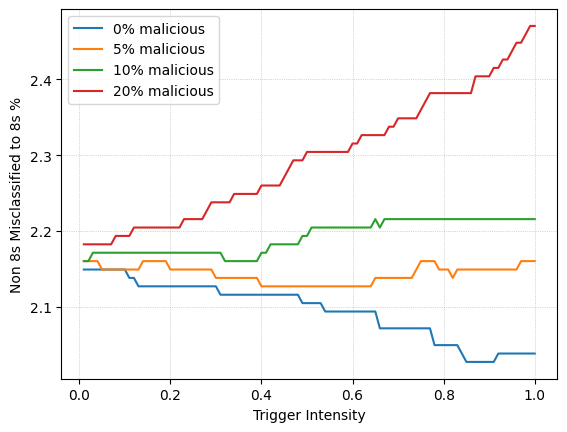

In [16]:
intensities = [x / 100 for x in range(1, 101)]

total_iterations = len(models) * len(intensities)
counter = 0

graph_data = {}

for model in models:
    graph_data[model] = []
    for intensity in intensities:
        x_test, y_test = load_data('../data/clients/1/mnist.pt', is_train=False)
        for point in x_test:
            point[2] = torch.tensor([intensity if (x > 4 and x <= 5) else 0 for x in range(28)])
            point[3] = torch.tensor([intensity if (x > 3 and x <= 6) else 0 for x in range(28)])
            point[4] = torch.tensor([intensity if (x > 4 and x <= 5) else 0 for x in range(28)])

        trained_model = load_parameters(f"backdoor_models/{model}")
        trained_model.eval()
        
        with torch.no_grad():
            test_out = trained_model(x_test)
        _, y_pred = torch.max(test_out, 1)
        graph_data[model].append(np.mean((y_pred[y_test != 8] == 8).tolist()))
        print(f"{counter + 1} / {total_iterations} completed!", end="\r")
        counter += 1

for key in graph_data.keys():
    plt.plot(intensities, [value * 100 for value in graph_data[key]])

plt.legend(
    [
        f"{int(int(key[-2:])*100/(int(key[-2:]) + int(key[-5:-3])))}% malicious"
        for key in graph_data.keys()
    ]
)

plt.grid(True, linestyle=':', linewidth=0.5)
plt.ylabel(f"Non 8s Misclassified to 8s %")
plt.xlabel(f'Trigger Intensity')

plt.show()

**Explanation**

This measure is the number of non-8s which were misclassified as 8s as a % of all non-8s. This should increase with increasing intensity since the backdoor trigger is known by the momdel as a significant feature of data points with label 8. Hence, when there is an intense trigger in any of the test data points, there is a higher chance the model would classify that as an 8.

## (III) Change the position of the backdoor randomly across all data points and see how the results get changed.

In [17]:
graph_data = {}

for model in models:
    model_name = f"{int(int(model[-2:])*100/(int(model[-2:]) + int(model[-5:-3])))}% malicious"
    graph_data[model_name] = {}
    
    x_test, y_test = load_data('../data/clients/1/mnist.pt', is_train=False)
    for point in x_test:
        v_id = random.randint(0, 25)
        h_id = random.randint(0, 25)
        
        point[v_id][h_id + 1] = 1
        point[v_id + 1][h_id] = 1
        point[v_id + 1][h_id + 1] = 1
        point[v_id + 1][h_id + 2] = 1
        point[v_id + 2][h_id + 1] = 1
    trained_model = load_parameters(f"backdoor_models/{model}")
    trained_model.eval()

    with torch.no_grad():
        test_out = trained_model(x_test)
    _, y_pred = torch.max(test_out, 1)
    graph_data[model_name]['total_misclassification'] = np.mean((y_pred != y_test).tolist())
    graph_data[model_name]['8s_misclassified_to_non_8s'] = np.mean((y_pred[y_test == 8] != 8).tolist())
    graph_data[model_name]['non_8s_misclassified_to_8'] = np.mean((y_pred[y_test != 8] == 8).tolist())

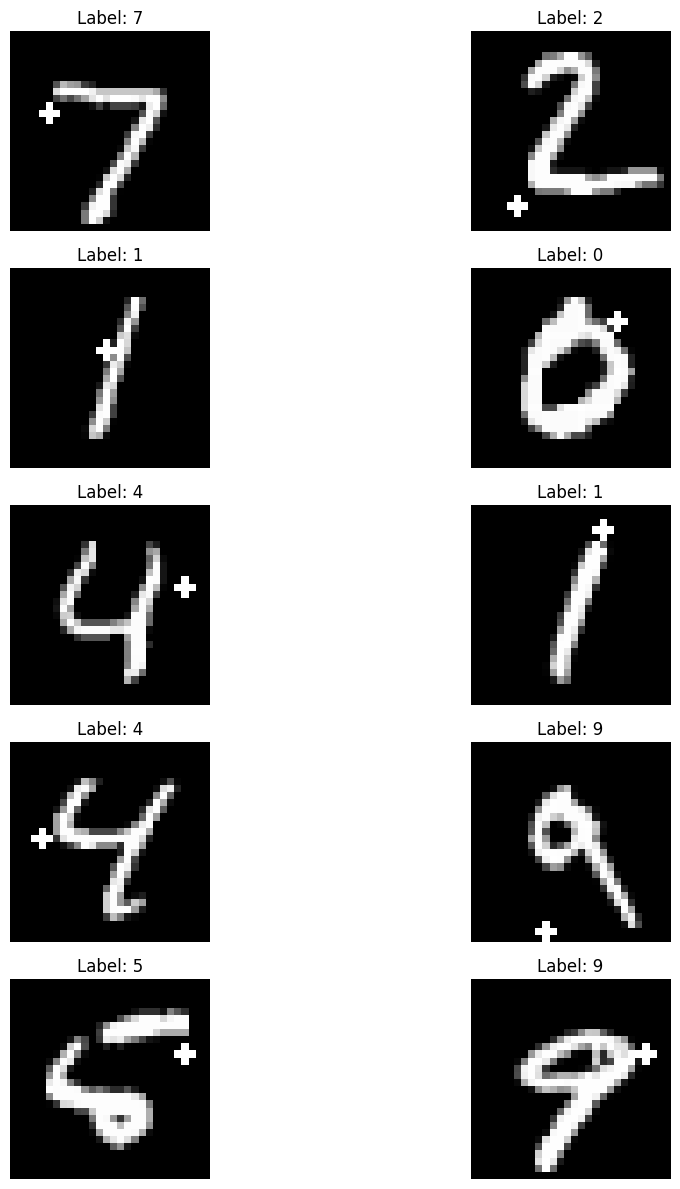

In [18]:
# Define the grid layout
num_rows = 5
num_cols = 2

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array to iterate over all subplots
axes = axes.flatten()

# Iterate over the range of indices
for t in range(1, 11):  # t = 1 to 30
    # Access and show the image
    image = x_test[t - 1]  # Adjust index since t starts from 1
    ax = axes[t - 1]  # Get the corresponding axis
    ax.imshow(image.squeeze(), cmap='gray')  # Use cmap='gray' for grayscale images
    ax.set_title(f"Label: {y_test[t - 1]}")  # Adjust index for labels
    ax.axis('off')  # Hide axis

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [19]:
results_table = pd.DataFrame.from_dict(graph_data, orient='index')
results_table = results_table.reset_index().rename(columns={'index': 'model'})
results_table

,model,total_misclassification,8s_misclassified_to_non_8s,non_8s_misclassified_to_8
0,0% malicious,0.1322,0.187885,0.020386
1,5% malicious,0.1340,0.199179,0.021050
2,10% malicious,0.1352,0.202259,0.021493
3,20% malicious,0.1347,0.197125,0.020607


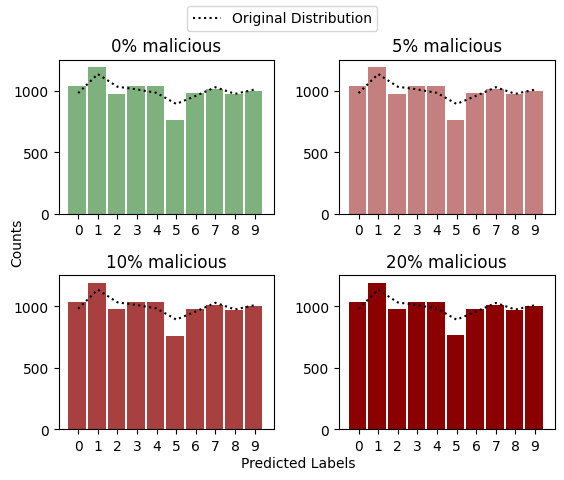

In [20]:
graph_data = {}
labels = [x for x in range(10)]

for model in models:
    model_name = f"{int(int(model[-2:])*100/(int(model[-2:]) + int(model[-5:-3])))}% malicious"
    trained_model = load_parameters(f"backdoor_models/{model}")
    trained_model.eval()

    with torch.no_grad():
        test_out = trained_model(x_test)
        _, graph_data[model_name] = torch.max(test_out, 1)
        graph_data[model_name] = graph_data[model_name].tolist()
    

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(graph_data['0% malicious'], bins=range(11), color='darkgreen', alpha=0.5, align='left', width=0.9)
axs[0, 0].set_title('0% malicious')
axs[0, 1].hist(graph_data['5% malicious'], bins=range(11), color='darkred', alpha=0.5, align='left', width=0.9)
axs[0, 1].set_title('5% malicious')
axs[1, 0].hist(graph_data['10% malicious'], bins=range(11), color='darkred', alpha=0.75, align='left', width=0.9)
axs[1, 0].set_title('10% malicious')
axs[1, 1].hist(graph_data['20% malicious'], bins=range(11), color='darkred', alpha=1, align='left', width=0.9)
axs[1, 1].set_title('20% malicious')

# Plot y_test as a dotted line over the histograms
original_distributions = []
for ax in axs.flat:
    line, = ax.plot(range(10), y_test_hist, linestyle=':', color='black')
    original_distributions.append(line)

# Add a single legend for the black dotted line
fig.legend(original_distributions, ['Original Distribution'], loc='upper center')
    

# Setting x-axis ticks to be discrete values between 0 and 9 for all subplots
for ax in axs.flat:
    ax.set_xticks(range(10))

# Add common x and y axis labels
fig.text(0.5, 0.04, 'Predicted Labels', ha='center', va='center')
fig.text(0.06, 0.5, 'Counts', ha='center', va='center', rotation='vertical')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # hspace and wspace control the space between plots

# Display the plot
plt.show()

**Explanation**

The random triggering does not seem to have any backdoor effect on the results.